<a href="https://colab.research.google.com/github/GonzaloRomeroR/CEIA/blob/main/vision_computadora_2/clase_2/VPC2_clase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio: Clase 2

Utilizando el dataset de señas de manos, crear una red neuronal con caracteristicas similares a las vistas en clase y entrenarla hasta obtener un accuracy de, como minimo, 85% evitando sobreentrenamiento. Aplicar las técnicas de data augmentation que consideren necesarias.

El dataset es un conjunto de imagenes de una mano realizando figuras de numeros del 0 al 5. El objetivo es clasificar a que digito corresponde cada imagen.

<img src="https://drive.google.com/uc?export=view&id=1Tm9arSkvypYpXzANQo4C2DtMWzkjA4hO" style="width:800px;height:300px;">

Para cargar en memoria el dataset suministrado pueden utilizar la siguiente función:




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
# Se importan las librerias a utilizar
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch.optim as optim
import albumentations
import albumentations.pytorch
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import transforms
from torchsummary import summary
import torch.nn.functional as F


In [39]:
# Funcion para cargar los datasets
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_x = np.array(train_dataset["train_set_x"][:])
    train_y = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('test_signs.h5', "r")
    test_x = np.array(test_dataset["test_set_x"][:])
    test_y = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])
    
    train_y = train_y.reshape((1, train_y.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))
    
    return train_x, train_y, test_x, test_y, classes

In [56]:
# Se definen las transformaciones a realizar para realizar data augmentation
torchvision_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(360),
    transforms.GaussianBlur(kernel_size=5),
])

In [41]:
# Se crea un dataset personalizado
class CustomDataset(Dataset):
  def __init__(self, X, Y, transform=None):
    super().__init__()
    self.X = X
    self.Y = Y
    self.transform = transform

  def __len__(self):
    return self.X.shape[0]
  
  def __getitem__(self, idx):
    if self.transform:
      image = self.transform(self.X[idx, :])
    return image, self.Y[idx]

In [42]:
# Se crean los datasets de train y tests
train_x, train_y, test_x, test_y, classes = load_dataset()
print("El conjunto de entrenamiento tiene {} imágenes".format(len(train_x)))
print("El conjunto de testeo tiene {} imágenes".format(len(test_x)))
print("Las imágenes son de: {}".format(train_x[0].shape))

El conjunto de entrenamiento tiene 1080 imágenes
El conjunto de testeo tiene 120 imágenes
Las imágenes son de: (64, 64, 3)


In [43]:
# Se reducen las dimesiones
train_y = np.squeeze(train_y)
test_y = np.squeeze(test_y)

Label de la imágen 0: 5
Label de la imágen 1: 0
Label de la imágen 2: 2
Label de la imágen 3: 5
Label de la imágen 4: 2
Label de la imágen 5: 4
Label de la imágen 6: 2
Label de la imágen 7: 1
Label de la imágen 8: 1


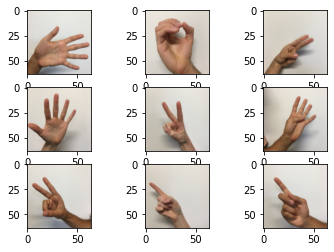

In [44]:
# Ploteo algunas imagenes del dataset y sus etiquetas
for i in range(9):
  plt.subplot(331 + i)
  plt.imshow(train_x[i], cmap=plt.get_cmap('gray'))
  print("Label de la imágen {}: {}".format(i, train_y[i]))

plt.show()

In [45]:
# Se normalizan las entradas
train_x = train_x / 255.0
test_x = test_x / 255.0

# Se toman muestras para validar
val_x = train_x[:100]
val_y = train_y[:100]

train_x = train_x[100:]
train_y = train_y[100:]

In [46]:
# Se define el modelo a entrenar
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(2704, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #x = self.softmax(x)
        return x

In [47]:
# Se definen los parámetros de entrada
params = {'batch_size': 64,
          'shuffle': True,}
max_epochs = 300

# Se cambian las dimensiones para realizar el entrenamiento
train_x_ = torch.Tensor(train_x).permute(0, 3, 1, 2)
train_y_ = torch.Tensor(train_y).type(torch.LongTensor)

val_x_ = torch.Tensor(val_x).permute(0, 3, 1, 2)
val_y_ = torch.Tensor(val_y).type(torch.LongTensor)

test_x_ = torch.Tensor(test_x).permute(0, 3, 1, 2)
test_y_ = torch.Tensor(test_y).type(torch.LongTensor)

print(train_x_.shape)

# Se crea el dataset y el dataloader
train_set = CustomDataset(train_x_, train_y_, torchvision_transform)
train_loader = torch.utils.data.DataLoader(train_set, **params)

val_set = CustomDataset(val_x_, val_y_, torchvision_transform)
val_loader = torch.utils.data.DataLoader(val_set, **params)

torch.Size([980, 3, 64, 64])


In [48]:
# Se definen los pesos iniciales
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


In [57]:
# Se crea la red
net = Net()
net.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9)
image, label = next(iter(train_set))
summary(net, (3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 60, 60]             456
         MaxPool2d-2            [-1, 6, 30, 30]               0
            Conv2d-3           [-1, 16, 26, 26]           2,416
         MaxPool2d-4           [-1, 16, 13, 13]               0
            Linear-5                  [-1, 120]         324,600
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 6]             510
Total params: 338,146
Trainable params: 338,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.31
Params size (MB): 1.29
Estimated Total Size (MB): 1.65
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  after removing the cwd from sys.path.


In [58]:
# Se entrena el modelo
losses_train = []
losses_val = []
running_loss = 0.0
for epoch in range(300):
    net.train()
    running_loss = 0.0
    correct = 0
    correct_val = 0
    net = net.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        _, preds = torch.max(outputs, 1)
        optimizer.step()
        running_loss += loss.item()
        correct += (preds == labels).float().sum()
    net = net.eval() 
    with torch.no_grad():
      valid_loss = 0.0
      for i, data in enumerate(val_loader):
          inputs, labels = data
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          valid_loss += loss.item()
          _, preds = torch.max(outputs, 1)
          correct_val += (preds == labels).float().sum()


    print('[%d] training loss: %.5f, validation loss: %.5f' %(epoch + 1, running_loss / len(train_loader), valid_loss / len(val_loader)), end="")
    print(", train accuracy {}, val accuracy {}".format(100 * correct / len(train_set), 100 * correct_val / len(val_set)))
    losses_train.append(running_loss / len(train_loader))
    losses_val.append(valid_loss / len(val_loader))

print('Finished Training')

[1] training loss: 1.79735, validation loss: 1.78825, train accuracy 17.040817260742188, val accuracy 26.0
[2] training loss: 1.78931, validation loss: 1.78798, train accuracy 18.87755012512207, val accuracy 18.0
[3] training loss: 1.78961, validation loss: 1.79194, train accuracy 19.387754440307617, val accuracy 17.0
[4] training loss: 1.78872, validation loss: 1.78814, train accuracy 19.387754440307617, val accuracy 18.0
[5] training loss: 1.78677, validation loss: 1.78280, train accuracy 22.244897842407227, val accuracy 23.0
[6] training loss: 1.78760, validation loss: 1.78253, train accuracy 20.918367385864258, val accuracy 22.0
[7] training loss: 1.78802, validation loss: 1.78840, train accuracy 19.795917510986328, val accuracy 14.0
[8] training loss: 1.78934, validation loss: 1.78694, train accuracy 17.85714340209961, val accuracy 28.0
[9] training loss: 1.78112, validation loss: 1.78517, train accuracy 24.489795684814453, val accuracy 23.0
[10] training loss: 1.78620, validation

Text(0.5, 0, 'epoch')

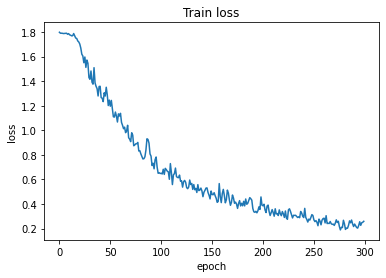

In [65]:
# Se grafica el error de entrenamiento
plt.plot(losses_train)
plt.title("Train loss")
plt.ylabel("loss")
plt.xlabel("epoch")

Text(0.5, 0, 'epoch')

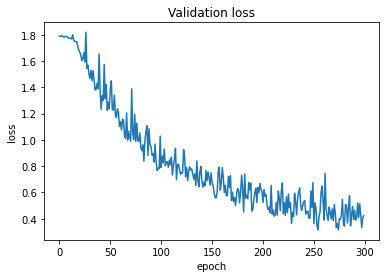

In [66]:
# Se grafica el error de validación
plt.plot(losses_val)
plt.title("Validation loss")
plt.ylabel("loss")
plt.xlabel("epoch")

In [67]:
# Se obtiene el error en el dataset de test
y_pred = np.argmax(net(test_x_).detach().numpy(), axis=1)
print("Error en test: {}".format(np.sum(test_y_.detach().numpy() == y_pred) / len(y_pred)))


Error en test: 0.9166666666666666
